In [1]:
import sys
sys.path.append('../..')
from explainn import tools
from explainn import networks
from explainn import train
from explainn import test
from explainn import interpretation

import torch
import os
from torch import nn
from sklearn.metrics import average_precision_score
from sklearn import metrics
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Train the ExplaiNN model on TF binding sites 

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Parameters
num_epochs = 20
batch_size = 100
learning_rate = 0.005 

# dataloaders2, target_labels2, train_out2 = tools.load_datas("../../data/test/tf_peaks_TEST_sparse_Remap.h5", batch_size,
#                                                          0, True)
dataloaders, target_labels, train_out = tools.load_datas("../../../SCRATCH/AS-TAC/AS-TAC__.h5", batch_size,
                                                         0, True)

target_labels = [i.decode("utf-8") for i in target_labels]
# target_labels2 = [i.decode("utf-8") for i in target_labels2]

num_cnns = 100
input_length = 1000
num_classes = len(target_labels)
filter_size = 19

cnn_deep = networks.ConvNetDeep(num_classes)
cnn_shallow = networks.ConvNetShallow(num_classes)
#danq = networks.DanQ(num_classes)
explainn = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(explainn.parameters(), lr=learning_rate)

weights_folder = "../../../SCRATCH/AS-TAC/ExplaiNN/single_train/JOB_ID/"
#os.makedirs(weights_folder)
name_ind = ""

Dataset Loaded


In [4]:
# training an individual model with 100 units
explainn_100, train_error, test_error = train.train_explainn(dataloaders['train'], dataloaders['valid'], explainn,
                                                device, criterion, optimizer, num_epochs,
                                                weights_folder, name_ind, verbose=True, trim_weights=False)

Epoch [1], Current Train Loss: 0.71687, Current Val Loss: 0.66944
Epoch [2], Current Train Loss: 0.60291, Current Val Loss: 0.66267
Epoch [3], Current Train Loss: 0.53314, Current Val Loss: 0.65450
Epoch [4], Current Train Loss: 0.47300, Current Val Loss: 0.64257
Epoch [5], Current Train Loss: 0.41732, Current Val Loss: 0.62641
Epoch [6], Current Train Loss: 0.36759, Current Val Loss: 0.60533
Epoch [7], Current Train Loss: 0.32750, Current Val Loss: 0.57797
Epoch [8], Current Train Loss: 0.29261, Current Val Loss: 0.54477
Epoch [9], Current Train Loss: 0.26627, Current Val Loss: 0.50788
Epoch [10], Current Train Loss: 0.24589, Current Val Loss: 0.46916
Epoch [11], Current Train Loss: 0.22938, Current Val Loss: 0.43373
Epoch [12], Current Train Loss: 0.21562, Current Val Loss: 0.40257
Epoch [13], Current Train Loss: 0.20475, Current Val Loss: 0.37743
Epoch [14], Current Train Loss: 0.19459, Current Val Loss: 0.35848
Epoch [15], Current Train Loss: 0.18495, Current Val Loss: 0.34513
Epoc

<Figure size 640x480 with 0 Axes>

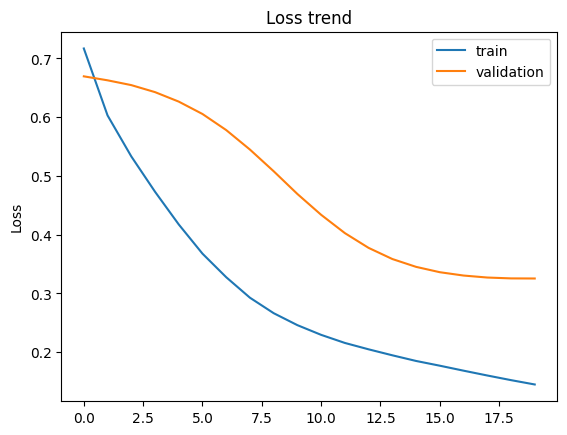

In [5]:
%matplotlib inline
tools.showPlot(train_error, test_error, "Loss trend", "Loss")

In [12]:
import tqdm
# Code to test how performance depends of the number of units
num_classes = len(target_labels) #number of classes
learning_rate = 0.01
num_epochs = 50
input_length = 1000
for num_cnns in range(25,126,50):
    if num_cnns == 0:
        num_cnns = 1    

    explainn = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(explainn.parameters(), lr=learning_rate)
    
    os.makedirs("../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_"+str(num_cnns))
    
    model, train_error, test_error = train.train_explainn(dataloaders['train'], dataloaders['valid'], explainn,
                                                device, criterion, optimizer, num_epochs,
                                                "../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_"+str(num_cnns)
                                                          , name_ind, verbose=True, trim_weights=False, checkpoint=False)
    
#old dir: ExplaiNN_filters_TF_binding/ExplaiNN_TF_num_cnns_
    print("Numm_cnns: " + str(num_cnns))
    print("Min test error: " + str(np.min(test_error)))

# testing
auprc_perf = {}
num_classes = len(target_labels)
for num_cnns in range(25,126,50):
    if num_cnns == 0:
        num_cnns = 1
    
    model = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)
    
    #load the best model
    #old dir: CAM_filters_TF_binding/CAM_TF_num_cnns_
    #find the file that contains "best" in its name in the dir os.listdir("../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_"+str(num_cnns)+"/")

    weight_file = os.listdir("../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_"+str(num_cnns)+"/")[0]
    
    model.load_state_dict(torch.load("../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_"+str(num_cnns)+"/"+weight_file))
    model.eval();

    labels_E, outputs_E = test.run_test(model, dataloaders['test'], device)
    
    auprc_perf[num_cnns] = average_precision_score(labels_E, outputs_E)
    
auprc_perf = pd.Series(auprc_perf)  

Epoch [1], Current Train Loss: 0.74555, Current Val Loss: 0.68055
Epoch [2], Current Train Loss: 0.67960, Current Val Loss: 0.66348
Epoch [3], Current Train Loss: 0.64174, Current Val Loss: 0.65037
Epoch [4], Current Train Loss: 0.60635, Current Val Loss: 0.64749
Epoch [5], Current Train Loss: 0.57068, Current Val Loss: 0.64729
Epoch [6], Current Train Loss: 0.53489, Current Val Loss: 0.64271
Epoch [7], Current Train Loss: 0.49999, Current Val Loss: 0.63991
Epoch [8], Current Train Loss: 0.46761, Current Val Loss: 0.63595
Epoch [9], Current Train Loss: 0.43696, Current Val Loss: 0.62842
Epoch [10], Current Train Loss: 0.40990, Current Val Loss: 0.61617
Epoch [11], Current Train Loss: 0.38245, Current Val Loss: 0.59399
Epoch [12], Current Train Loss: 0.35973, Current Val Loss: 0.56516
Epoch [13], Current Train Loss: 0.33908, Current Val Loss: 0.52872
Epoch [14], Current Train Loss: 0.32006, Current Val Loss: 0.49530
Epoch [15], Current Train Loss: 0.30419, Current Val Loss: 0.46456
Epoc

c:\Users\aslak\anaconda3\envs\testy\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\aslak\anaconda3\envs\testy\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\aslak\anaconda3\envs\testy\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\aslak\anaconda3\envs\testy\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\aslak\anaconda3\envs\testy\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\aslak\anaconda3\envs\testy

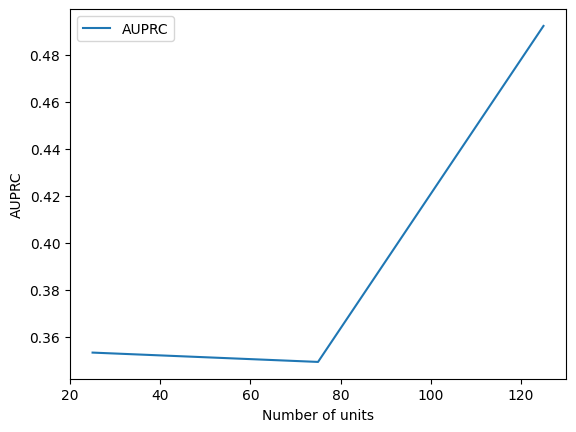

In [13]:
#plot auprc_perf with respect to the number of units and show legend and save the plot
plt.plot(auprc_perf)
plt.xlabel("Number of units")
plt.ylabel("AUPRC")
plt.legend(["AUPRC"])
plt.savefig("../../../SCRATCH/AS-TAC/ExplaiNN/single_train/AUPRC_num_units.png")

In [6]:
# performances for individual TFs (classes)
explainn_100.eval()
labels_E, outputs_E = test.run_test(explainn_100, dataloaders['test'], device)

no_skill_probs = [0 for _ in range(len(labels_E[:,0]))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(labels_E[:,0], no_skill_probs)

roc_aucs = {}
raw_aucs = {}
roc_prcs = {}
raw_prcs = {}
for i in range(len(target_labels)):
    nn_fpr, nn_tpr, threshold = metrics.roc_curve(labels_E[:,i], outputs_E[:,i])
    roc_auc_nn = metrics.auc(nn_fpr, nn_tpr)
    
    precision_nn, recall_nn, thresholds = metrics.precision_recall_curve(labels_E[:,i], outputs_E[:,i])
    pr_auc_nn = metrics.auc(recall_nn, precision_nn)
    
    roc_aucs[target_labels[i]] = nn_fpr, nn_tpr
    raw_aucs[target_labels[i]] = roc_auc_nn
    
    roc_prcs[target_labels[i]] = recall_nn, precision_nn
    raw_prcs[target_labels[i]] = pr_auc_nn
    
raw_prcs_explainn = pd.Series(raw_prcs)
raw_aucs_explainn = pd.Series(raw_aucs)

c:\Users\aslak\anaconda3\envs\testy\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\aslak\anaconda3\envs\testy\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\aslak\anaconda3\envs\testy\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\aslak\anaconda3\envs\testy\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\aslak\anaconda3\envs\testy\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users

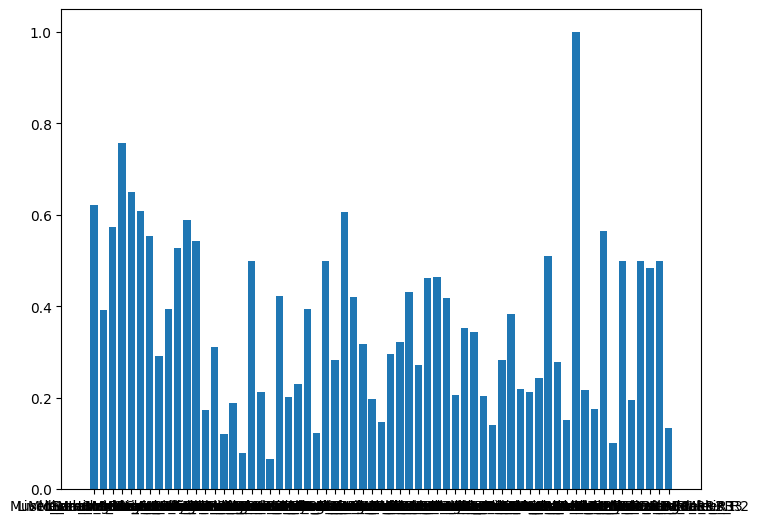

In [7]:
# AUPRC
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
TFs = raw_prcs_explainn.index[:63]
AUPRC = raw_prcs_explainn.values[:63]
ax.bar(TFs,AUPRC)
plt.show()

In [54]:
print(TFs)

Index(['Liver_Mature_Male_R1', 'MidSomitogenesis_R1',
       'Muscle_Immature_Female_R3', 'Muscle_Mature_Male_R3',
       'LateSomitogenesis_R3', 'Liver_Immature_Female_R1',
       'Gonad_Immature_Female_R3', 'MidGastrulation_R3', 'MidGastrulation_R1',
       'Muscle_Mature_Female_R3', 'LateSomitogenesis_R1',
       'Brain_Immature_Male_R2', 'Gonad_Immature_Male_R1',
       'Liver_Immature_Female_R2', 'LateBlastulation_R3',
       'EarlySomitogenesis_R1', 'MidSomitogenesis_R3',
       'Liver_Mature_Female_R3', 'Brain_Mature_Male_R1',
       'Liver_Immature_Male_R3', 'Liver_Mature_Female_R2',
       'Brain_Immature_Male_R3', 'Brain_Immature_Female_R3',
       'Gonad_Immature_Female_R2', 'LateSomitogenesis_R2',
       'Brain_Mature_Female_R2', 'Gonad_Mature_Female_R3',
       'Brain_Mature_Male_R2', 'EarlySomitogenesis_R3',
       'Brain_Immature_Male_R1', 'Liver_Mature_Male_R3',
       'Muscle_Mature_Female_R2', 'Muscle_Immature_Female_R1',
       'Brain_Immature_Female_R2', 'Brain_Matu

# Interpretation

In [8]:
num_cnns=100
explainn = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)

weight_file = os.listdir("../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_"+str(num_cnns)+"/")[0]

explainn.load_state_dict(torch.load("../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_"+str(num_cnns)+"/"+weight_file))
explainn.eval()
    

ExplaiNN(
  (linears): Sequential(
    (0): Conv1d(400, 100, kernel_size=(19,), stride=(1,), groups=100)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ExpActivation()
    (3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Unsqueeze()
    (6): Conv1d(14000, 10000, kernel_size=(1,), stride=(1,), groups=100)
    (7): BatchNorm1d(10000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(10000, 100, kernel_size=(1,), stride=(1,), groups=100)
    (11): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (final): Linear(in_features=100, out_features=63, bias=True)
)

In [17]:
#explainn
#"../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_"+str(num_cnns)+"/"+weight_file
arr_comp

array([[False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True, False,  True],
       ...,
       [ True,  True, False, ...,  True, False,  True],
       [ True, False,  True, ..., False, False,  True],
       [False, False, False, ...,  True,  True, False]])

In [14]:
dataset, data_inp, data_out = tools.load_single_data("../../../SCRATCH/AS-TAC/AS-TAC_50K.h5", batch_size, 1, False)
predictions, labels = interpretation.get_explainn_predictions(dataset, explainn, device, isSigmoid=True)

# only well predicted sequences
pred_full_round = np.round(predictions)
arr_comp = np.equal(pred_full_round, labels)
idx = np.argwhere(np.sum(arr_comp, axis=1) == len(target_labels)).squeeze()

data_inp = data_inp[idx, :, :]
data_out = data_out[idx, :]

dataset = torch.utils.data.TensorDataset(data_inp, data_out)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, shuffle=False,
                                                  num_workers=0)

activations = interpretation.get_explainn_unit_activations(data_loader, explainn, device)
pwms = interpretation.get_pwms_explainn(activations, data_inp, filter_size)
interpretation.pwm_to_meme(pwms, "../../../SCRATCH/AS-TAC/ASSY.meme")

  0%|                    | 0/0 [00:00<?, ?it/s]


AxisError: axis 2 is out of bounds for array of dimension 1

In [ ]:
#explore my torch.utils.data.dataset.TensorDataset object "dataset"
dataset.tensors[0].shape

In [ ]:
%%bash

./../../../meme-5.3.3/src/tomtom -o ../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_$num_cnns data/TFBS.meme ../../../SCRATCH/downloads/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt

In [ ]:
tomtom_results = pd.read_csv(f"../../../tomtom_results/tomtom_TF_binding/tomtom_CAM_{num_cnns}/tomtom.tsv",
                                        sep="\t",comment="#")

filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]

tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]

cisbp_motifs = {}
with open("../../../tomtom_results/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt") as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            cisbp_motifs[name_m] = motif

filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]
    if len(target_id) > 5:
        target_id = target_id[:5]
    ann = "/".join([cisbp_motifs[i] for i in target_id.values])
    annotation[f] = ann

annotation = pd.Series(annotation)
annotation

In [51]:
weights = explainn.final.weight.detach().cpu().numpy()

filters = ["filter"+str(i) for i in range(num_cnns)]
for i in annotation.keys():
    filters[int(i.split("filter")[-1])] = annotation[i]
    
weight_df = pd.DataFrame(weights,index=target_labels,columns=filters)
weight_df.shape

NameError: name 'annotation' is not defined

In [ ]:
sns.clustermap(weight_df,cmap=sns.diverging_palette(145, 10, s=60, as_cmap=True), 
               row_cluster=True, figsize=(30,20), vmax=0.5, vmin = -0.5)

In [ ]:
#only annotated columns
ann_wdf = weight_df.loc[:,["filter" not in i for i in list(weight_df)]]

clust = sns.clustermap(ann_wdf, cmap='vlag',#cmap=sns.diverging_palette(145, 10, s=60, as_cmap=True), 
               row_cluster=True, figsize=(30,20), vmax=0.5, vmin = -0.5)

## Importance scores

In [ ]:
unit_outputs = interpretation.get_explainn_unit_outputs(dataloaders['valid'], explainn, device)

unit_importance = interpretation.get_specific_unit_importance(activations, explainn, unit_outputs, 19, target_labels)

filter_key = "filter"+str(19)
title = annotation[filter_key] if filter_key in annotation.index else filter_key
fig, ax = plt.subplots()
datas = [filt_dat for filt_dat in unit_importance]
ax.boxplot(datas, notch=True, patch_artist=True, boxprops=dict(facecolor="#228833", color="#228833"))
fig.set_size_inches(18.5, 10.5)
plt.title(title)
plt.ylabel("Unit importance")
plt.xticks(range(1, len(target_labels)+1), target_labels)
plt.xticks(rotation=90)
plt.show()